# Feature 2 - Top people on Messenger

This feature extracts the information from the messages sub folder of the main folder uploaded
and gives the Top 5 most people/ groups messaged using Facebook

In [1]:
import os
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

Extracts the user name so that we can check if the user is an active participant of any groups on messenger(sends messages) 

In [2]:
os.chdir("C:/Users/Gowtham/PycharmProjects/Ethi_Facebook_Data_Analysis/facebook-sampledataset")
folders = os.listdir()
def user_name():
    for folder in folders:
        if "profile_information" == folder:
                    with open(folder + "/" + "profile_information.json") as input:
                        data = json.load(input)
                        return (data["profile"]["name"]["full_name"])

Preprocesses the group name/ User name - By removing special characters and emoji's

In [3]:
def preprocess(text):
    text = re.sub(r"[.*?\|\/:]", " ", text)
    text = re.sub(r"[^A-Za-z0-9]+", " ", text)
    return (text)

# This brachart function displays the bargraph horizontally

In [4]:
def barchart(messages, names, plot_name):
    # Reverses the names so that the bar chart is in ascending order
    names = (names.iloc[::-1])
    y_pos = np.arange(len(names))
    # Plots a horizontal bar chart
    plt.barh(y_pos, sorted(messages))
    plt.yticks(y_pos, names)
    plt.suptitle(plot_name)
    plt.savefig(plot_name+".png", bbox_inches="tight")
    plt.show()

Function to create a csv file

In [5]:
def top_friends_messenger(data, file_name):
    data.to_csv(file_name + ".csv", encoding='utf-8', index=False)

# The function *messages_data* creates two dataframe - Top 5 Active groups and Top 5 close people on messenger


In [6]:
def recent_messages(foldername):
    duration = 6
    group_messages_count = 0
    individual_messages_count = 0
    messenger_groups = {}
    messgenger_personal_accounts = {}
    user = user_name()
    for cur, _dirs, files in os.walk(foldername):
        for file in files:
            # Only json file is needed to be parsed
            if file.endswith(".json"):
                with open(cur + "/" + file) as input:
                    data = json.load(input)
                    for i in data["messages"]:
                        dt_object = datetime.datetime.fromtimestamp(int(i["timestamp_ms"]) / 1000)
                        last_six_months = date.today() + relativedelta(months=-duration)
                        if (dt_object.date() > last_six_months):
                            if len(data["participants"]) < 3:
                                for participant in data["participants"]:
                                    if participant["name"] != data["title"]:
                                        if i["sender_name"] == participant["name"]:
                                            individual_messages_count += 1
                                    else:
                                        friends = preprocess(participant["name"])
                            if len(data["participants"]) >= 3:
                                group_name = preprocess(data["title"])
                                if i["sender_name"] == user:
                                    group_messages_count += 1

                    if individual_messages_count > 0:
                        try:
                            if friends not in messgenger_personal_accounts:
                                messgenger_personal_accounts[friends] = individual_messages_count
                            else:
                                messgenger_personal_accounts[friends] += individual_messages_count
                        except:
                            pass
                    if group_messages_count > 0:
                        if group_name not in messenger_groups:
                            messenger_groups[group_name] = group_messages_count
                        else:
                            messenger_groups[group_name] += group_messages_count
                    individual_messages_count = 0
                    group_messages_count = 0

    personal_messages = dict(sorted(messgenger_personal_accounts.items(), key=lambda x: x[1], reverse=True))
    group_messages = dict(sorted(messenger_groups.items(), key=lambda x: x[1], reverse=True))
    df_groups = pd.DataFrame(group_messages.items(),
                             columns=["Group Name", "Number of Messages you shared with the group"])
    top_friends_messenger(df_groups, "groups")
    df_groups = df_groups.head()
    df_personal_messages = pd.DataFrame(personal_messages.items(),
                                        columns=["Account Name", "Number of messages you have sent"])
    top_friends_messenger(df_personal_messages, "friends")
    df_personal_messages = df_personal_messages.head()
    barchart(df_groups["Number of Messages you shared with the group"], df_groups["Group Name"], "Top 5 Active Groups")
    barchart(df_personal_messages["Number of messages you have sent"], df_personal_messages["Account Name"],"Top 5 close people on messenger")


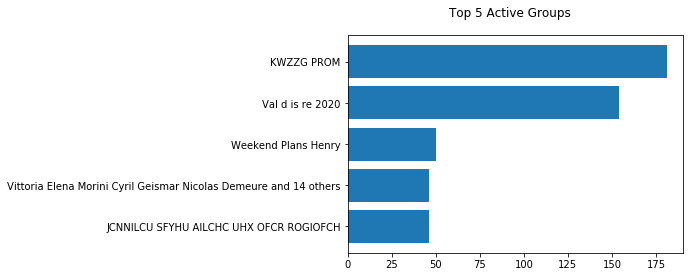

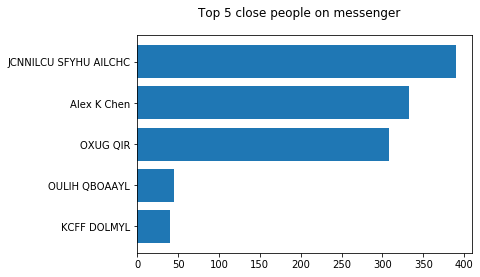

In [7]:
def main(sub_folders):
    recent_messages(sub_folders)
main("messages")